# Demo Artifact Notebook

This notebook contains code for blind users' gesture recognition algorithm for the AccessWear paper. 

## Import basic libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from dtaidistance import dtw

## Load predefined nucleus templates for gestures

These templates are manually extracted from a sighted user's gyroscope sensor data.

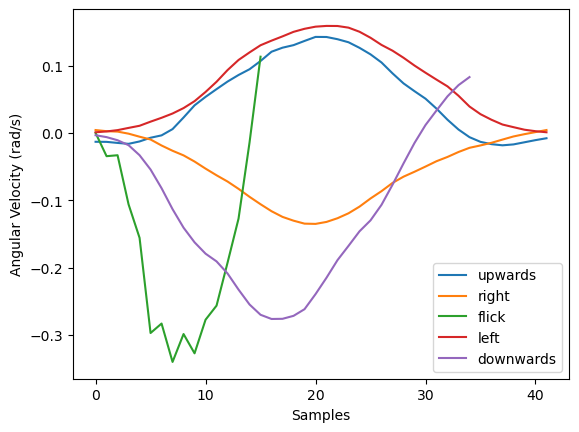

In [3]:
upwards = [-0.013134999999999999, -0.013257, -0.014846000000000002, -0.016189000000000002, -0.012646, -0.0071486, -0.0036055999999999996, 0.0056795, 0.022906000000000003, 0.040987, 0.053571, 0.065056, 0.076295, 0.08606899999999999, 0.094621, 0.10684, 0.12064, 0.12663, 0.13042, 0.13665, 0.14264, 0.14251, 0.13921, 0.13469, 0.12639, 0.11673, 0.10464, 0.088513, 0.07360799999999999, 0.062000999999999994, 0.050884, 0.036101, 0.019607, 0.0050686, -0.0062934, -0.013257, -0.016678000000000002, -0.018389, -0.017044999999999998, -0.013868, -0.010692, -0.0078817]
right = [0.0042921, 0.0025817, 0.0019708, -0.0010834999999999998, -0.0056039, -0.0097578, -0.018676, -0.026495, -0.033337, -0.042499999999999996, -0.053007000000000006, -0.062903, -0.072188, -0.083062, -0.094912, -0.10590999999999999, -0.11629, -0.12472000000000001, -0.13033999999999998, -0.13474, -0.13511, -0.13218000000000002, -0.12668, -0.11935, -0.10945, -0.097356, -0.086482, -0.074265, -0.06498000000000001, -0.05765, -0.049953, -0.042011, -0.035658, -0.028328, -0.022097, -0.018554, -0.014645, -0.00988, -0.0052374, -0.0018166000000000002, 0.0012378, 0.0042921]
flick =  [-1.7180922e-05, -0.034531035, -0.033126056, -0.10612437, -0.1558488, -0.29720286, -0.28315303, -0.34014663, -0.29873005, -0.32737955, -0.277472, -0.25651923, -0.19274506, -0.12726027, -0.014128193, 0.11323717]
left = [0.00099342, 0.0022151000000000002, 0.0041699, 0.007468600000000001, 0.010645, 0.016753999999999998, 0.022496, 0.028849000000000003, 0.036912, 0.047175, 0.060858, 0.07600799999999999, 0.093356, 0.10838, 0.11961999999999999, 0.13025, 0.13709, 0.14345000000000002, 0.15017, 0.15469, 0.15786, 0.15896, 0.15884, 0.1564, 0.15028999999999998, 0.14137, 0.13074, 0.12219, 0.11168, 0.10007999999999999, 0.089447, 0.079184, 0.069166, 0.055237999999999995, 0.039234000000000005, 0.027871, 0.019564, 0.012478, 0.008568099999999999, 0.0047808, 0.0025817, 0.00099342]
downwards = [-0.00341394, -0.00622392, -0.01086649, -0.01819687, -0.033101969999999994, -0.05436006, -0.08209332, -0.11324743, -0.14073634, -0.16248312, -0.17934299, -0.19082725, -0.20878665000000002, -0.23273256, -0.25484586, -0.27011747, -0.2763483, -0.27610395, -0.27170572000000004, -0.26180970000000003, -0.23945208, -0.21501749, -0.18887248, -0.16773655, -0.14611195, -0.12986294, -0.10677226, -0.07696205, -0.04531927, -0.0148982, 0.0117355, 0.033360112, 0.054373859999999996, 0.07098938, 0.08296233]

## Plotting templates for vizualization
plt.plot(upwards, label='upwards')
plt.plot(right, label='right')
plt.plot(flick, label='flick')
plt.plot(left, label='left')
plt.plot(downwards, label='downwards')
plt.legend()
plt.xlabel('Samples')
plt.ylabel('Angular Velocity (rad/s)')
plt.show()

## Read a data file from the 'blind_user_sample_data' directory
Data format: gesture_sample.csv

Gestures are as follows:

1 --> move forearm upwards  

2 --> move forearm horizontally towards right  

3 --> flick wrist  

4 --> move forearm horizontally towards left  

5 --> move forearm downwards

In [340]:
## TODO: change the file name to the file you want to test
file = 'blind_user_sample_data/5_1.csv'

## Pre-process data
Find the significant axis of the gesture, i.e. the axis which has the most rotation

In [341]:
df = pd.read_csv(file)

def significant_axis(df):
    """function for checking for the axis with maximum 
    rotation in the gyroscope data

    input: dataframe (Pandas DataFrame)
    output: significant axis (Series) and axis number (int)
    """
    max_x = np.max(df['gx'])
    max_y = np.max(df['gy'])
    max_z = np.max(df['gz'])

    max_axis = np.max([max_x, max_y, max_z])
    if(max_axis == max_x):
        sig_axis = df['gx']
        axis = 1

    elif(max_axis == max_y):
        sig_axis = df['gy']
        axis = 2
    else:
        sig_axis = df['gz']
        axis = 3    
    return sig_axis, axis

sig_axis, axis = significant_axis(df)

## Nucleus Detection
Each individual has a unique style in which they move their arm and hands. Upon observing
the gyroscope data of different users at a more granular level, we find that despite the differences in gesture patterns, each gesture exhibits a distinct signature.
This signature, "nucleus" is the core of the gesture and is consistent across users for the same gesture. 

To extract the nucleus, we first calculate the RMS energy of the gesture. Empirically we use a sliding window size of 20. 

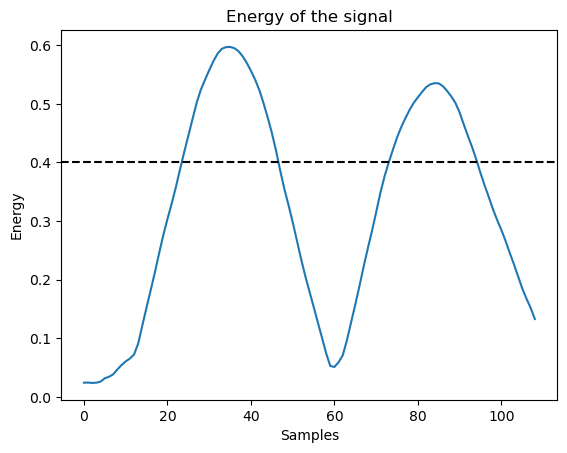

In [342]:
def calculate_energy(sig_axis, window=20):
    """
    function for calculating the energy of the signal
    
    input: signficant axis (Series), window size (int)
    output: energy of the signal (list)"""
    energy = []

    for i in range(len(sig_axis)-window):
        x = sig_axis[i:i+window]
        N = len(x)
        squared_sum = sum([val**2 for val in x])
        energy.append(math.sqrt(1/N * squared_sum))
    return energy

energy = calculate_energy(sig_axis)
figure = plt.figure()
plt.plot(energy)
plt.axhline(0.4, color='k', linestyle='--')
plt.xlabel('Samples')
plt.ylabel('Energy')
plt.title('Energy of the signal')

plt.show()

Next, we localize the nucleus in this above energy signal. To localize the nucleus, we implement a lightweight change point detection algorithm.

We examine the difference in RMSE using windows. When the difference in energy between the reference and the new window exceeds an empirically determined threshold (0.4), the change points are noted. We filter out the change points that are too close to each other.
The nucleus is determined by two change points. 

actual change points:  [31, 32, 33, 34, 35, 60, 61, 62, 63, 64, 81, 82]
filtered change points:  [31, 60]


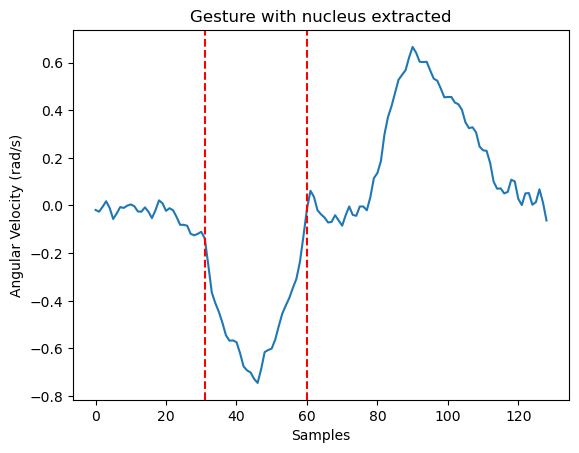

In [343]:
## nucleus detection
def detect_nucleus(energy, window=20, nucleus_thres=0.4):
    """
    function for detecting the nucleus in the gestures
    
    input: energy of the signal (list), window size (int), nucleus threshold (float)
    output: nucleus points (list)
    """
    change_pts = []

    ## use sliding window to find changes in energy
    for i in range(len(energy)-15):
        if(abs(energy[i+15]-energy[i]) > nucleus_thres):
            change_pts.append(i)

    change_pts = list(map(lambda x: x + window, change_pts))
    print("actual change points: ", change_pts)

    ## filter out the change points that are too close to each other
    filtered_change_pts = [change_pts[0]]
    for i in range(1, len(change_pts)):
        if(change_pts[i] - filtered_change_pts[-1] >= window):
            filtered_change_pts.append(change_pts[i])

    filtered_change_pts = filtered_change_pts[:2]
    print("filtered change points: ", filtered_change_pts)

    if(len(filtered_change_pts) == 1):
        filtered_change_pts.append(change_pts[-1]+10)
    
    return filtered_change_pts

filtered_change_pts = detect_nucleus(energy)

figure = plt.figure()
plt.plot(sig_axis)
plt.xlabel('Samples')
plt.ylabel('Angular Velocity (rad/s)')
plt.title('Gesture with nucleus extracted')

for i in filtered_change_pts:
    plt.axvline(i, color='r', linestyle='--')  
plt.show()

## get the nucleus
nucleus = list(sig_axis[filtered_change_pts[0]:filtered_change_pts[1]+10])

## Distinguishing forearm and wrist movements
The nucleus of a forearm and a wrist gesture could look similar. We observe that due to the impulse-like nature of the wrist gesture, jitters are observed
in the nucleus. 
To identify these jitters, we implement a light weight peak detection algorithm.

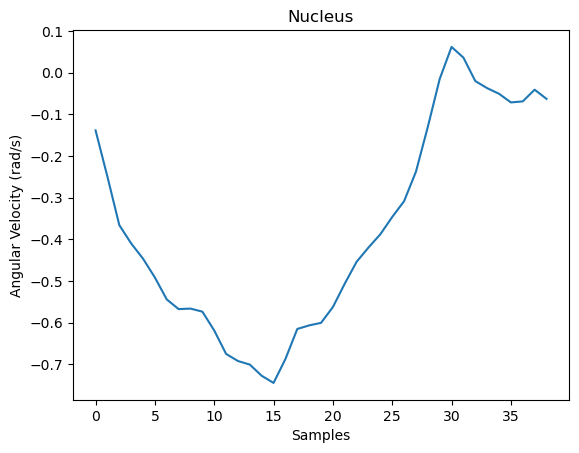

In [344]:
abs_nuc = np.abs(nucleus)
plt.plot(nucleus)
plt.ylabel('Angular Velocity (rad/s)')
plt.xlabel('Samples')
plt.title('Nucleus')
plt.show()


## jitter detection for wrist gesture
def jitter_detection(abs_nuc, peak_height=0.9):
    """
    function for detecting jitters in the nucleus
    
    input: absolute nucleus (list), peak height (float)
    output: boolean for jitter (bool)
    """
    wrist_bool = False
    jitter = []

    max_h = peak_height*max(abs_nuc)

    for i in range(len(abs_nuc)):
        if(abs_nuc[i] >= max_h):
            jitter.append(i)    
            
    if(len(jitter) < 5):
        wrist_bool = True
        print("wrist gesture probable")
    return wrist_bool

wrist_bool = jitter_detection(abs_nuc)

## Recognizing the gestures
In this step, we match the detected nucleus against pre-defined gesture templates. We use DTW to match these two signals.

In [345]:
distance1 = 100000
distance2 = 100000
distance3 = 100000
distance4 = 100000
distance5 = 100000

gesture_list = ['forearm upwards', 'forearm horizontally right', 'flick  wrist', 
                'forearm horizontally left', 'forearm downwards']

if(axis == 2 or axis == 1 and wrist_bool == False):
    distance1 = dtw.distance_fast(np.array(nucleus), np.array(upwards))

if (axis == 3):
    distance2 = dtw.distance_fast(np.array(nucleus), np.array(right))

if (((axis == 1 or axis == 2) and wrist_bool == True)):
    distance3 = dtw.distance_fast(np.array(nucleus),  np.array(flick))

if (axis == 3):
    distance4 = dtw.distance_fast(np.array(nucleus),  np.array(left))

if ((axis == 2 or axis == 1 and wrist_bool == False)):
    distance5 = dtw.distance_fast(np.array(nucleus),  np.array(downwards))
                    
distances = [distance1, distance2, distance3, distance4, distance5]

print("actual gesture is: ", gesture_list[int(file.split('/')[1].split('_')[0])-1])

## remove any false negatives: 
# if the minimum distance is less than 50, 
# then it is a gesture
if(np.min(distances) < 50):
    print("detected gesture is: ", gesture_list[np.argmin(distances)])
else:
    print("no gesture detected")

actual gesture is:  forearm downwards
detected gesture is:  forearm downwards
